In [1]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate,ChatPromptTemplate
from langchain_google_genai import GoogleGenerativeAIEmbeddings,ChatGoogleGenerativeAI
from langchain_chroma import Chroma
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.tools import tool
from typing_extensions import TypedDict
from typing import List, Dict, Any, Tuple, Optional,Union
from langgraph.graph import StateGraph,START,END,MessagesState
from langgraph.types import Literal,Command
from langchain_core.messages import SystemMessage,AIMessage,HumanMessage
from langgraph.prebuilt import create_react_agent,tools_condition,tool_node
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import create_tool_calling_agent, AgentExecutor
from pydantic import BaseModel,Field
from langchain.schema import Document
from langchain.agents import tool_calling_agent
import tqdm
from dotenv import load_dotenv
load_dotenv()

d:\Conda\envs\langchain\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
from retriever import contextual_embedding_bm25_retriever_rerank

In [3]:
memory = MemorySaver()
config = {'configurable':{'thread_id':"1"}}

In [4]:
@tool
def contexual_retriever(query: str) -> List[str]:
    """
    Retrieve all relevant documents with similarity threshold filtering (>50%).

    Provide very large,or large detailed answers if needed.
    The agent should try to return comprehensive context rather than short responses.

    Args:
        query (str): Search query string.
        
    Returns:
        List[Union[str, Document]]: All Document objects with relevance_score > 0.5,
                                    sorted by relevance_score in descending order,
                                    or ["Answer is not in Database"] if no matches.
        
    Example:
        >>> results = contexual_retreiver("What is edge computing architecture?")
        >>> for doc in results:
        >>>     print(f"Score: {doc.metadata['relevance_score']}")
        >>>     print(f"Content: {doc.page_content}\n")
    """
    # Get all results from the retriever using the input query as is.
    results = contextual_embedding_bm25_retriever_rerank.invoke(query)
    
    #Filter results that have a relevance_score > 0.5 (i.e., >50%).
    filtered_results = [
        doc for doc in results 
        if doc.metadata.get('relevance_score', 0.0) > 0.5
    ]
    
    # Sort the filtered results by relevance_score in descending order.
    filtered_results.sort(
        key=lambda x: x.metadata.get('relevance_score', 0.0),
        reverse=True
    )

    
    if not filtered_results:
        return ["Answer is not in Database"]
    
    return filtered_results

In [5]:
llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash',temperature=0)
retrieve_agent = create_react_agent(llm, tools=[contexual_retriever])

In [6]:
query_llm = ChatGoogleGenerativeAI(model='gemini-1.5-flash',temperature=0)

In [7]:
class Router(BaseModel):
    goto: Literal['query_creator', 'study_assistant'] = Field(
        description=(
            "Given a user query to you, You choose the next node to go to. "
            "The name of the node to go to. Use 'query_creator' if the user's request is related to study questions about stored documents, "
            "note that each subject has 5 units of PDFs covering the following subjects: DeepLearning AI, Edge Computing, "
            "LargeLanguageModels, Security Essentials in Applied AI, and Distributed DataProcessing with Spark. "
            "This node will generate a query for retrieval from the stored vectorbase to perform RAG."
            "Otherwise, use 'study_assistant' for direct responses."
        )
    )

In [8]:
model = ChatGoogleGenerativeAI(model='gemini-1.5-pro',temperature=0)
model_structured = model.with_structured_output(Router)

In [9]:
# response = model_structured.invoke("What is the edge computing architecture?")
# getattr(response,'goto')

In [10]:
study_assistant_model = ChatGoogleGenerativeAI(model='gemini-2.0-flash',temperature=0)

In [11]:
# response = retrieve_agent.invoke({"messages":"How to make biriyani?"})
# for msg in response['messages']:
#     msg.pretty_print()

In [12]:
# response['messages'][-1].content

In [13]:
query_instruct = SystemMessage(content="""You need to create a query , which will be passed to a contextual retriever tool.
                               The retriever is connected to a vectorsore to do similarity search on the documents in the database. 
                               The retriever will return the most relevant documents based on the query. 
                               The documents will be used to generate a response to your question.
                               Make sure to provide a query that only beautfies the user's question and does not add any new information, or change its meaning.)
                               Please provide a query to search for relevant documents in the database.""")

In [14]:
study_instruct = SystemMessage(content="""You are an study assistant , you need to provide a detailed answer to the user's question.
                               You can provide detailed answers to the user's questions based on your knowledge.""")

In [15]:
study_instruct_with_response = SystemMessage(content="""You are an study assistant , you need to provide a detailed answer to the user's question.
                                             You are given a response from a contextual retriever tool and also the User's question.
                                             Use the retrieved answers and the user's question to provide a detailed response.
                                             If the retrieved answers are not sufficient, you can provide your own answers.
                                             If the retrieved answers are not relevant, you can provide your own answers.""")

In [16]:
class State(MessagesState):
    query: str
    response : str
    goto : str

In [17]:
def router(state:State)->Command[Literal["query_creator","study_assistant"]]:
    answer = model_structured.invoke(state["messages"][-1].content)
    response = getattr(answer,"goto")
    goto = response
    return Command(goto=goto,update={"goto":goto,"messages":state["messages"]})

In [18]:
def query_creator(state:State)->State:
    response = query_llm.invoke([query_instruct]+[state['messages'][-1].content])
    state['query'] = response.content
    state['query'] = state['query']
    return state

In [19]:
def retriever_agent(state:State)->State:
    response = retrieve_agent.invoke({"messages":HumanMessage(content=state['query'])})
    state['response'] = response['messages'][-1].content
    state['response'] = state['response']
    return state

In [20]:
def study_assistant(state:State)->State:
    if state['goto']=='query_creator':
        print("human query" , state['messages'][-1].content)
        print("response from agent",state['response'])
        response = study_assistant_model.invoke([study_instruct_with_response]+[state['response']]+[state['messages'][-1].content])
        state['response'] = None
        state['messages'] = state['messages']+[response]
    else:
        response = study_assistant_model.invoke([study_instruct]+state['messages'])
        state['messages'] = state['messages']+[response]
    return state

In [21]:
graph_builder = StateGraph(State)
graph_builder.add_node("router",router)
graph_builder.add_node("study_assistant",study_assistant)
graph_builder.add_node("query_creator",query_creator)
graph_builder.add_node("retriever_agent",retriever_agent)

In [22]:
graph_builder.add_edge(START,"router")
graph_builder.add_edge("query_creator","retriever_agent")
graph_builder.add_edge("retriever_agent","study_assistant")
graph_builder.add_edge("study_assistant",END)

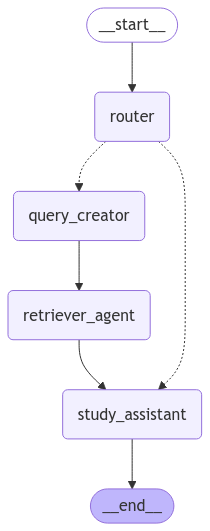

In [23]:
graph_builder.compile()

In [24]:
graph = graph_builder.compile(checkpointer=memory)

In [25]:
# response = graph.invoke({"messages":HumanMessage(content="What is the edge computing architecture?")},config=config)

In [26]:
# for msg in response['messages']:
#     msg.pretty_print()

In [27]:
response_1 = graph.invoke({"messages":HumanMessage(content="Which page contains transformer architecture in the document?")},config=config)

human query Which page contains transformer architecture in the document?
response from agent Pages 8, 16, 5 and 6 of Artificial_Intelligence_DL_GenAI_Unit4.pdf, pages 2, 13, 22, and 25 of LLM_Large_Language_Models_Unit2.pdf and page 13 of LLM_Large_Language_Models_Unit1.pdf contain information on transformer architecture.



In [28]:
for msg in response_1['messages']:
    msg.pretty_print()

================================ Human Message =================================

Which page contains transformer architecture in the document?
================================== Ai Message ==================================

Based on the information provided, the following pages contain information on transformer architecture:

*   **Artificial\_Intelligence\_DL\_GenAI\_Unit4.pdf:** Pages 5, 6, 8, and 16
*   **LLM\_Large\_Language\_Models\_Unit2.pdf:** Pages 2, 13, 22, and 25
*   **LLM\_Large\_Language\_Models\_Unit1.pdf:** Page 13


In [29]:
response_2 = graph.invoke({"messages":HumanMessage(content="My name is Gokul,You gotta teach me how to not procrastinate and be productive")},config=config)
for msg in response_2['messages']:
    msg.pretty_print()

================================ Human Message =================================

Which page contains transformer architecture in the document?
================================== Ai Message ==================================

Based on the information provided, the following pages contain information on transformer architecture:

*   **Artificial\_Intelligence\_DL\_GenAI\_Unit4.pdf:** Pages 5, 6, 8, and 16
*   **LLM\_Large\_Language\_Models\_Unit2.pdf:** Pages 2, 13, 22, and 25
*   **LLM\_Large\_Language\_Models\_Unit1.pdf:** Page 13
================================ Human Message =================================

My name is Gokul,You gotta teach me how to not procrastinate and be productive
================================== Ai Message ==================================

Alright Gokul, let's tackle procrastination and boost your productivity. It's a common struggle, but definitely one you can overcome. We'll break it down into understanding why you procrastinate, practical strategies t

In [30]:
response_3 = graph.invoke({"messages":HumanMessage(content="What is my name that I introduced to you a while ago?")},config=config)
for msg in response_3['messages']:
    msg.pretty_print()

================================ Human Message =================================

Which page contains transformer architecture in the document?
================================== Ai Message ==================================

Based on the information provided, the following pages contain information on transformer architecture:

*   **Artificial\_Intelligence\_DL\_GenAI\_Unit4.pdf:** Pages 5, 6, 8, and 16
*   **LLM\_Large\_Language\_Models\_Unit2.pdf:** Pages 2, 13, 22, and 25
*   **LLM\_Large\_Language\_Models\_Unit1.pdf:** Page 13
================================ Human Message =================================

My name is Gokul,You gotta teach me how to not procrastinate and be productive
================================== Ai Message ==================================

Alright Gokul, let's tackle procrastination and boost your productivity. It's a common struggle, but definitely one you can overcome. We'll break it down into understanding why you procrastinate, practical strategies t

In [31]:
response_4 = graph.invoke({"messages":HumanMessage(content="What is GDPR about?Where and which page or document it is mentioned in?")},config=config)
for msg in response_4['messages']:
    msg.pretty_print()

================================ Human Message =================================

Which page contains transformer architecture in the document?
================================== Ai Message ==================================

Based on the information provided, the following pages contain information on transformer architecture:

*   **Artificial\_Intelligence\_DL\_GenAI\_Unit4.pdf:** Pages 5, 6, 8, and 16
*   **LLM\_Large\_Language\_Models\_Unit2.pdf:** Pages 2, 13, 22, and 25
*   **LLM\_Large\_Language\_Models\_Unit1.pdf:** Page 13
================================ Human Message =================================

My name is Gokul,You gotta teach me how to not procrastinate and be productive
================================== Ai Message ==================================

Alright Gokul, let's tackle procrastination and boost your productivity. It's a common struggle, but definitely one you can overcome. We'll break it down into understanding why you procrastinate, practical strategies t

In [32]:
response_5 = graph.invoke({"messages":HumanMessage(content="No GDPR is not in llm unit 1 page 20. can you check again?")},config=config)
for msg in response_5['messages']:
    msg.pretty_print()

human query No GDPR is not in llm unit 1 page 20. can you check again?
response from agent I'm sorry, but I did not find any information about GDPR being mentioned on page 20 of LLM unit 1.

================================ Human Message =================================

Which page contains transformer architecture in the document?
================================== Ai Message ==================================

Based on the information provided, the following pages contain information on transformer architecture:

*   **Artificial\_Intelligence\_DL\_GenAI\_Unit4.pdf:** Pages 5, 6, 8, and 16
*   **LLM\_Large\_Language\_Models\_Unit2.pdf:** Pages 2, 13, 22, and 25
*   **LLM\_Large\_Language\_Models\_Unit1.pdf:** Page 13
================================ Human Message =================================

My name is Gokul,You gotta teach me how to not procrastinate and be productive
================================== Ai Message ==================================

Alright Gokul, let's tackle

In [33]:
response_5 = graph.invoke({"messages":HumanMessage(content="Where is GDPR mentioned in , I think its in Security essentials modules can you check?")},config=config)
for msg in response_5['messages']:
    msg.pretty_print()

human query Where is GDPR mentioned in , I think its in Security essentials modules can you check?
response from agent GDPR is mentioned in the Security Essentials modules in the following contexts:

*   **GDPR Compliance Principles:** The modules discuss GDPR as a data protection and privacy law in the EU, emphasizing its aim to give individuals control over their personal data and simplify the regulatory environment for international business.
*   **Data Minimization:** AI systems should only collect the data necessary for their specific purpose, ensuring that personal data is not excessively gathered or stored beyond the time required for processing, aligning with GDPR principles.
*   **Data Protection Impact Assessments (DPIA):** The modules highlight the importance of DPIAs to assess the impact of data processing activities on individual privacy and ensure compliance with data protection laws like GDPR.
*   **GDPR-Compliant Data Processing:** AI models can be designed to minimize 

In [34]:
response_6 = graph.invoke({"messages":HumanMessage(content="Which page and document is it in?")},config=config)
for msg in response_6['messages']:
    msg.pretty_print()

human query Which page and document is it in?
response from agent I'm sorry, I need more information to fulfill this request. Please specify the content you are looking for. For example, you could ask: "Which page and document contains information about edge computing architecture?"

================================ Human Message =================================

Which page contains transformer architecture in the document?
================================== Ai Message ==================================

Based on the information provided, the following pages contain information on transformer architecture:

*   **Artificial\_Intelligence\_DL\_GenAI\_Unit4.pdf:** Pages 5, 6, 8, and 16
*   **LLM\_Large\_Language\_Models\_Unit2.pdf:** Pages 2, 13, 22, and 25
*   **LLM\_Large\_Language\_Models\_Unit1.pdf:** Page 13
================================ Human Message =================================

My name is Gokul,You gotta teach me how to not procrastinate and be productive
===============

In [35]:
response_7 = graph.invoke({"messages":HumanMessage(content="Which page and document contains information about GDPR in Security Essentials?")},config=config)
for msg in response_7['messages']:
    msg.pretty_print()

human query Which page and document contains information about GDPR in Security Essentials?
response from agent Information about GDPR in Security Essentials can be found on the following pages and documents:

*   **Document:** Security Essentials in Applied AI\_Unit4.pdf
    *   **Page Number:** 15
    *   **Page Number:** 21
    *   **Page Number:** 18
    *   **Page Number:** 22
    *   **Page Number:** 3
    *   **Page Number:** 2
    *   **Page Number:** 4
================================ Human Message =================================

Which page contains transformer architecture in the document?
================================== Ai Message ==================================

Based on the information provided, the following pages contain information on transformer architecture:

*   **Artificial\_Intelligence\_DL\_GenAI\_Unit4.pdf:** Pages 5, 6, 8, and 16
*   **LLM\_Large\_Language\_Models\_Unit2.pdf:** Pages 2, 13, 22, and 25
*   **LLM\_Large\_Language\_Models\_Unit1.pdf:** Pag